In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm
import math

%matplotlib inline

%load_ext autoreload
%autoreload 2

/media/kaitopia/3-software/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def gen_data(n, test, plot=False, dim=2):
    assert dim >= 2
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    n_test = int(n * test)
    n_train = n - n_test

    for i in range(n_train):
        theta = np.random.random() * 2 * np.pi
        tmp = np.random.random() * 2
        r = np.sqrt(tmp if tmp <=1 else tmp + 1)
        train_x.append([r * np.sin(theta), r * np.cos(theta)] + list(np.random.randn(dim - 2)))
        train_y.append(1 if r <= 1 else 0)

    for i in range(n_test):
        theta = np.random.random() * 2 * np.pi
        tmp = np.random.random() * 2
        r = np.sqrt(tmp if tmp <=1 else tmp + 1)
        test_x.append([r * np.sin(theta), r * np.cos(theta)] + list(np.random.randn(dim - 2)))
        test_y.append(1 if r <= 1 else 0)

    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)

    if plot:
        plt.figure()
        show_data(train_x, train_y, title="training data")
        show_data(test_x, test_y, title="testing data")

    tmp = train_y.copy()
    train_y = np.zeros((tmp.shape[0], 2))
    train_y[np.arange(tmp.shape[0]), tmp] = 1

    tmp = test_y.copy()
    test_y = np.zeros((tmp.shape[0], 2))
    test_y[np.arange(tmp.shape[0]), tmp] = 1

    return train_x, train_y, test_x, test_y

def show_data(x, y, title):
    label_1 = np.where(y == 1)
    label_0 = np.where(y == 0)
    plt.plot(x[label_0][:, 0], x[label_0][:, 1], "*")
    plt.plot(x[label_1][:, 0], x[label_1][:, 1], "*")
    plt.title(title)
    plt.show()


In [3]:
def fc_layer(inputs, input_sz, output_sz, name="fc"):
    with tf.name_scope(name):
        W = tf.get_variable('{}/W'.format(name), [input_sz, output_sz],
#             initializer=tf.zeros_initializer()
            initializer=tf.random_normal_initializer(stddev=1 / math.sqrt(input_sz))
        )
        b = tf.get_variable('{}/b'.format(name), [output_sz],
            initializer=tf.zeros_initializer())
        outputs = tf.tanh(tf.matmul(inputs, W) + b)
        tf.summary.histogram("weights", W)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", outputs)
        return outputs
        
def build_model(input_sz, num_classes, lr_rate, reg_strength):
    hidden_sz_1 = 4
    hidden_sz_2 = 2
    x = tf.placeholder(tf.float32, [None, input_sz], name="x")
    y = tf.placeholder(tf.float32, [None, num_classes], name="labels")
    fc1 = fc_layer(x, input_sz, hidden_sz_1, name="fc1")
    fc2 = fc_layer(fc1, hidden_sz_1, hidden_sz_2, name="fc2")
    score = fc_layer(fc2, hidden_sz_2, num_classes, name="fc3")
    with tf.name_scope("loss"):
        with tf.name_scope("cross_entropy"):
            xent = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=score, labels=y)
            )
        with tf.name_scope("l2_regularization"):
            l2s = []
            for name in ["fc1", "fc2", "fc3"]:
                with tf.variable_scope("", reuse=True):
                    l2s.append(tf.nn.l2_loss(tf.get_variable("{}/W".format(name))))
            l2_loss = reg_strength * tf.add_n(l2s)
        loss = xent + l2_loss

    with tf.name_scope("train"):
        train_step = tf.train.GradientDescentOptimizer(
            learning_rate=lr_rate).minimize(loss)
    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("loss", loss)
    tf.summary.scalar("accuracy", accuracy)
    merged_summary = tf.summary.merge_all()

    return x, y, train_step, loss, accuracy, merged_summary

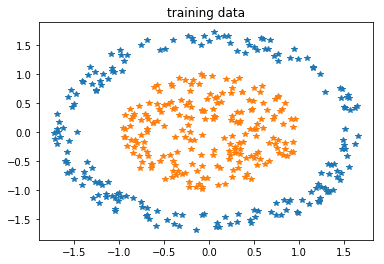

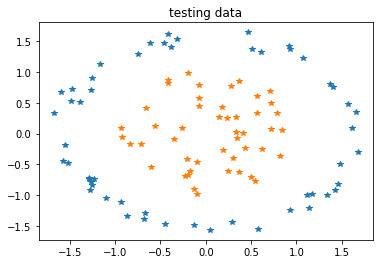

In [4]:
train_x, train_y, test_x, test_y = gen_data(n=500, test=.2, dim=10, plot=True)
input_x, input_y, train_op, loss, acc, merged_summary = build_model(
    input_sz=train_x.shape[1], num_classes=train_y.shape[1], lr_rate=.3, reg_strength=1e-2)
n_epoch = 100
batch_sz = 10
init = tf.global_variables_initializer()
losses = []

In [5]:
# tensorboard --logdir tmp/deep_learning_demo/...
writer = tf.summary.FileWriter("tmp/deep_learning_demo/{}".format(
    time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
))
with tf.Session() as sess:
    writer.add_graph(sess.graph)
    sess.run(init)
    for i in tqdm.tqdm(range(n_epoch)):
        idx = np.random.permutation(train_x.shape[0])
        iters = int(train_x.shape[0] / batch_sz)
        batch_losses = []
        for j in range(iters):
            batch_xs, batch_ys = (
                train_x[idx[j * batch_sz: (j + 1) * batch_sz]],
                train_y[idx[j * batch_sz: (j + 1) * batch_sz]])
            res = sess.run([loss, train_op],
                feed_dict={input_x: batch_xs, input_y: batch_ys})
            batch_losses.append(res[0])
        losses.append(sum(batch_losses) / len(batch_losses))
        s = sess.run(merged_summary,
                feed_dict={input_x: batch_xs, input_y: batch_ys})
        writer.add_summary(s, i)
    test_acc = sess.run(acc, feed_dict={input_x: test_x, input_y: test_y})
    print("Test accuracy is %f." % test_acc)


100%|██████████| 100/100 [00:08<00:00, 12.25it/s]

Test accuracy is 0.970000.
